In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.stats
#plt.style.use("project_style.mplstyle")
from tqdm import tqdm

import analysis_tools
import stats

In [2]:
# load model
if trajectories := True:
    model_type = "RNN"
else:
    model_type = "FF"

name = "al1_10_l2_0"
path = f"../models/{name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = model_type) # model of interest

timesteps = 20000 # timesteps per sequence

In [3]:
sequence = ["square"]*1 # eval on test dataset

Text(0, 0.5, 'Euclidean Error')

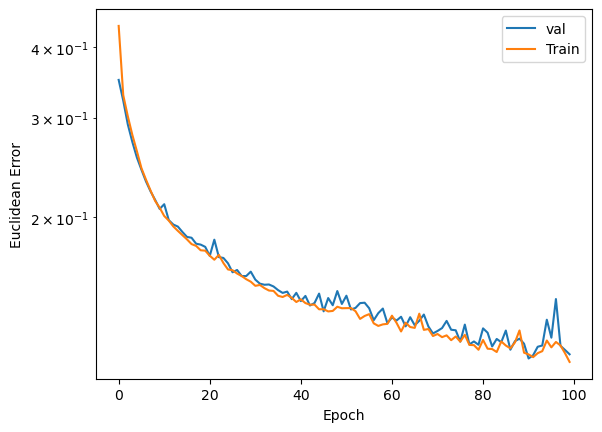

In [4]:
training_losses = np.load(f"{path}/{model_type}_metrics.npz")
val_euclid = training_losses["val_euclid"]
train_euclid = training_losses["train_euclid"]

plt.plot(val_euclid, label = "val")
plt.semilogy(train_euclid, label = "Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Euclidean Error")

In [5]:
x, r0, v, c = analysis_tools.test_dataset(sequence, timesteps = timesteps, 
                                         context = params["context"], 
                                         trajectories = True) # create dataset

In [6]:
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
g, p, cen, yhat0 = model.inference(dataset)

In [7]:
states = [x[0]]
yhat, g, p, mu = model(x)
if not trajectories:
    for i in range(len(model.g)-1):
        if i % 2 == 0:
            states.append(model.g[i](states[-1]))
states.append(g)
states.append(p)
states = [state.detach().numpy() for state in states]

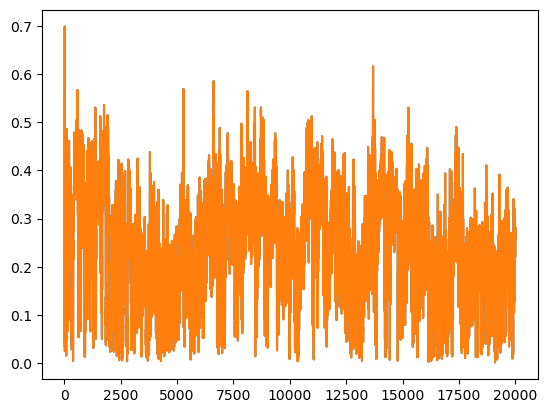

In [8]:
zz0 = np.linalg.norm(r0 - yhat0, axis = -1)
zz = np.linalg.norm(r0 - yhat.detach().numpy(), axis = -1)

plt.plot(np.mean(zz, axis=0))
plt.plot(np.mean(zz0, axis=0))

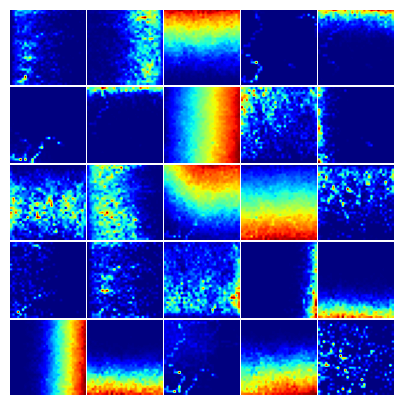

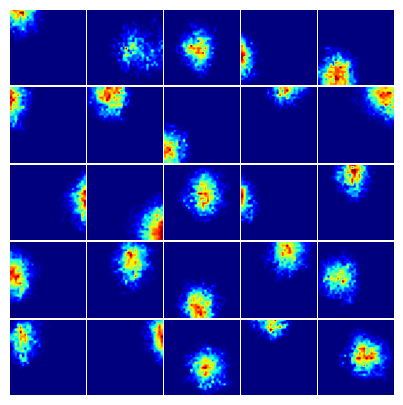

In [63]:
r = np.reshape(r0, (-1, r0.shape[-1]))

bins = [32, 32]

for i in range(1, len(states)):
    mask = (np.nanmean(states[i], axis = (0,1)) > 1e-5) .astype("bool")
    state = states[i][:,:,mask] 
    ratemaps = stats.population_vector_ratemaps(state.reshape((-1, state.shape[-1]))[None], r[None], bins, smooth = False)
    analysis_tools.plot_ensemble(ratemaps[0], 5);
    plt.subplots_adjust(wspace = -0.025, hspace = 0.025)
    plt.savefig(f"./figures/{name}_{model_type}_state_{i}")

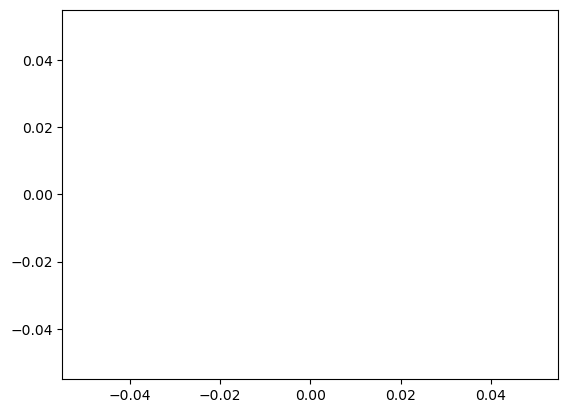

In [10]:
 yhat = yhat.detach().numpy()


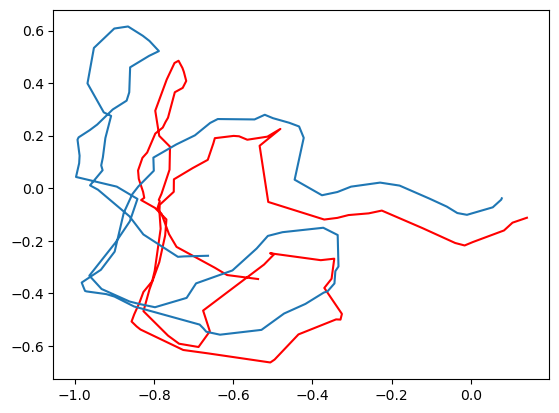

In [51]:
plt.plot(yhat[0, 5000:5100, 0], yhat[0, 5000:5100, 1], "r")
plt.plot(r0[0,5000:5100,0],r0[0,5000:5100,1])

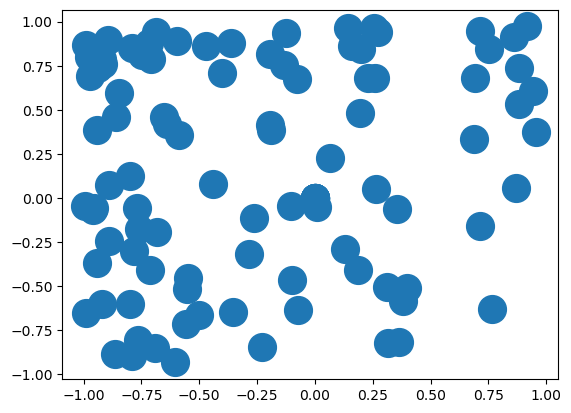

In [57]:
plt.plot(cen[0,:,0], cen[0,:,1], "o", markersize = 20)